  # Homework 3 - Ames Housing Dataset

For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## **Begining, Definitions**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import make_scorer

In [0]:
data_path = "./drive/My Drive/DSF/hw3/data/" # colab path

In [0]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None  # default='warn'

In [0]:
def rmsle(true, pred):
    true, pred = np.exp(true), np.exp(pred) # used logarithmic target values so...
    return -np.sqrt(mean_squared_error(np.log(true), np.log(pred)))

**load data**

In [0]:
train_data_full = pd.read_csv(data_path + 'train.csv')

In [0]:
test_data_full = pd.read_csv(data_path + 'test.csv')

In [0]:
train_data_full.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000,1460.000,1460,1201.000,1460.000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000,1460.000,1460.000,1460.000,1460,1460,1460,1460,1452,1452.000,1460,1460,1460,1423,1423,1422,1423,1460.000,1422,1460.000,1460.000,1460.000,1460,...,1460,1459,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460,1460.000,1460,1460.000,770,1379,1379.000,1379,1460.000,1460.000,1379,1379,1460,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,7,281,54,1460.000,1460.000,1460.000,1460,1460,1460.000
unique,nan,nan,5,nan,nan,2,2,4,4,2,5,3,25,9,8,5,8,nan,nan,nan,nan,6,8,15,16,4,nan,4,5,6,4,4,4,6,nan,6,nan,nan,nan,6,...,2,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4,nan,7,nan,5,6,nan,3,nan,nan,5,5,3,nan,nan,nan,nan,nan,nan,3,4,4,nan,nan,nan,9,6,nan
top,nan,nan,RL,nan,nan,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,nan,nan,nan,nan,Gable,CompShg,VinylSd,VinylSd,None,nan,TA,TA,PConc,TA,TA,No,Unf,nan,Unf,nan,nan,nan,GasA,...,Y,SBrkr,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,TA,nan,Typ,nan,Gd,Attchd,nan,Unf,nan,nan,TA,TA,Y,nan,nan,nan,nan,nan,nan,Gd,MnPrv,Shed,nan,nan,nan,WD,Normal,nan
freq,nan,nan,1151,nan,nan,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,nan,nan,nan,nan,1141,1434,515,504,864,nan,906,1282,647,649,1311,953,430,nan,1256,nan,nan,nan,1428,...,1365,1334,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,735,nan,1360,nan,380,870,nan,605,nan,nan,1311,1326,1340,nan,nan,nan,nan,nan,nan,3,157,49,nan,nan,nan,1267,1198,nan
mean,730.500,56.897,NaN,70.050,10516.828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099,5.575,1971.268,1984.866,NaN,NaN,NaN,NaN,NaN,103.685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.640,NaN,46.549,567.240,1057.429,NaN,...,NaN,NaN,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,NaN,6.518,NaN,0.613,NaN,NaN,1978.506,NaN,1.767,472.980,NaN,NaN,NaN,94.245,46.660,21.954,3.410,15.061,2.759,NaN,NaN,NaN,43.489,6.322,2007.816,NaN,NaN,180921.196
std,421.610,42.301,NaN,24.285,9981.265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.383,1.113,30.203,20.645,NaN,NaN,NaN,NaN,NaN,181.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098,NaN,161.319,441.867,438.705,NaN,...,NaN,NaN,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,NaN,1.625,NaN,0.645,NaN,NaN,24.690,NaN,0.747,213.805,NaN,NaN,NaN,125.339,66.256,61.119,29.317,55.757,40.177,NaN,NaN,NaN,496.123,2.704,1.328,NaN,NaN,79442.503
min,1.000,20.000,NaN,21.000,1300.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1872.000,1950.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.000,NaN,...,NaN,NaN,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,2.000,NaN,0.000,NaN,NaN,1900.000,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,1.000,2006.000,NaN,NaN,34900.000
25%,365.750,20.000,NaN,59.000,7553.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,5.000,1954.000,1967.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,223.000,795.750,NaN,...,NaN,NaN,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,NaN,5.000,NaN,0.000,NaN,NaN,

Lots of NaNs!!

In [0]:
train_data_full.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
train_ids = train_data_full['Id']
test_ids = test_data_full['Id']

In [0]:
train_data_full = train_data_full.drop('Id', axis=1)
test_data = test_data_full.drop('Id', axis=1)

In [0]:
train_length = len(train_data_full)
test_length = len(test_data_full)

In [0]:
train_sp = np.log(train_data_full['SalePrice'])
train_data = train_data_full.drop('SalePrice', axis=1)

In [0]:
print(train_data.shape, test_data.shape)

(1460, 79) (1459, 79)


In [0]:
full_data = pd.concat((train_data, test_data)).reset_index()

# as I found out there are many nan values and categorical columns. So concating train and test data for encoding and imputation. Later I can split it using train_length.

In [0]:
full_data.head()

,index,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000,Unf,0.000,150.000,856.000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.000,0.000,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2.000,548.000,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000,Unf,0.000,284.000,1262.000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.000,1.000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2.000,460.000,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000,Unf,0.000,434.000,920.000,GasA,Ex,Y,SBrkr,920,866,0,1786,1.000,0.000,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2.000,608.000,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000,Unf,0.000,540.000,756.000,GasA,Gd,Y,SBrkr,961,756,0,1717,1.000,0.000,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3.000,642.000,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000,Unf,0.000,490.000,1145.000,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.000,0.000,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3.000,836.000,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [0]:
full_data = full_data.drop('index', axis=1)

In [0]:
full_data.select_dtypes(include = 'number').columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [0]:
full_data.select_dtypes(include = 'object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [0]:
time_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

In [0]:
interesting_cols = ['LotArea', 
        'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 
        'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 
        '1stFlrSF', '2ndFlrSF',
        'GrLivArea', 
        'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 
        'GarageArea', 
        'PoolArea',
        'YrSold',
        'SalePrice']

## **Pre Processing Approach 1**

**drop unnecessary data**

In [0]:
# def drop_cols(df):
  
#   threshold = 0.6
#   highly_nan_columns = df.columns[df.isna().sum()/len(df) > threshold].tolist()
#   df = df.drop(highly_nan_columns, axis=1)
  
#   threshold = 0.8
#   for col in df.columns[1:]:
#     if df[col].value_counts().max() / len(df) > threshold:
#       df = df.drop(col, axis=1)
    
#   return df

In [0]:
# temp = 0
# for col in train_data_full.columns[1:]:
#   if train_data_full[col].value_counts().max() / len(train_data_full) > 0.8:
#     train_data_full = train_data_full.drop(col, axis=1)
#     temp+=1

# print(temp, 'columns removed')
    
# threshold = 0.6
# highly_nan_columns = train_data_full.columns[train_data_full.isna().sum()/len(train_data_full) > threshold].tolist()
# train_data_full = train_data_full.drop(highly_nan_columns, axis=1)
# print(len(highly_nan_columns), 'columns removed')

**encode**

In [0]:
# def encode_manually(df):
#   qual_columns = [
#     'FireplaceQu',
#     'KitchenQual',
#     'HeatingQC',
#     'BsmtQual',
#     'ExterQual'
#   ]
#   quals = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
#   dict5 = {key:val for key, val in zip( quals, range(len(quals),0,-1))}
#   dict4 = {key:val for key, val in zip( quals[:-1], range(len(quals[:-1]),0,-1))}


#   for col in qual_columns:
#     if df[col].nunique() == 5:
#       df[col] = df[col].replace(dict5).fillna(0)
#     elif df[col].nunique() == 4:
#       df[col] = df[col].replace(dict4).fillna(0)
#     else:
#       print(col)
      
#   col = 'GarageFinish'
#   dictGarageFinish = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA':0}
#   df[col] = df[col].replace(dictGarageFinish)
#   df[col] = df[col].fillna(df[col].mean())    
  
#   bsmtFinQual = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
#   col = 'BsmtFinType1'
#   dictBsmtFin = {key:val for key, val in zip( bsmtFinQual, range(len(bsmtFinQual),0,-1))}
#   df[col] = df[col].replace(dictBsmtFin)
#   df[col] = df[col].fillna(df[col].mean())
  
#   bsmtExpQual = ['Gd','Av','Mn','No','NA']
#   col = 'BsmtExposure'
#   dictBsmtExp = {key:val for key, val in zip( bsmtExpQual, range(len(bsmtExpQual),0,-1))}
#   df[col] = df[col].replace(dictBsmtExp)
#   df[col] = df[col].fillna(df[col].mean())
  
#   return df

In [0]:
# # train_data_full = train_data_full_copy.copy()
# qual_columns = [
#     'FireplaceQu',
#     'KitchenQual',
#     'HeatingQC',
#     'BsmtQual',
#     'ExterQual'
# ]
# quals = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
# dict5 = {key:val for key, val in zip( quals, range(len(quals),0,-1))}
# dict4 = {key:val for key, val in zip( quals[:-1], range(len(quals[:-1]),0,-1))}


# for col in qual_columns:
#   if train_data_full[col].nunique() == 5:
#     train_data_full[col] = train_data_full[col].replace(dict5).fillna(0)
#   elif train_data_full[col].nunique() == 4:
#     train_data_full[col] = train_data_full[col].replace(dict4).fillna(0)
#   else:
#     print(col)
# print(len(qual_columns), 'columns processed')    

In [0]:
# # train_data_full = train_data_full_copy.copy()
# col = 'GarageFinish'
# dictGarageFinish = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA':0}
# train_data_full[col] = train_data_full[col].replace(dictGarageFinish)
# train_data_full[col] = train_data_full[col].fillna(train_data_full[col].mean())

In [0]:
# bsmtFinQual = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
# col = 'BsmtFinType1'
# dictBsmtFin = {key:val for key, val in zip( bsmtFinQual, range(len(bsmtFinQual),0,-1))}
# train_data_full[col] = train_data_full[col].replace(dictBsmtFin)
# train_data_full[col] = train_data_full[col].fillna(train_data_full[col].mean())

In [0]:
# bsmtExpQual = ['Gd','Av','Mn','No','NA']
# col = 'BsmtExposure'
# dictBsmtExp = {key:val for key, val in zip( bsmtExpQual, range(len(bsmtExpQual),0,-1))}
# train_data_full[col] = train_data_full[col].replace(dictBsmtExp)
# train_data_full[col] = train_data_full[col].fillna(train_data_full[col].mean())

In [0]:
# train_data_full = encode_manually(train_data_full)

In [0]:
# test_data = encode_manually(test_data)

**NAN**

In [0]:
# # low_nan_columns = ['LotFrontage', 'MasVnrArea', 'MasVnrType', 'GarageType', 'GarageYrBlt']
# # print(train_data_full[low_nan_columns].describe(include='all'))

# def fillnan(df):
#   nan_columns = df.columns[df.isna().any()]
#   for col in nan_columns:
#     if col in time_cols:
#       print('time', col)
#       df[col] = df[col].fillna(df[col].mean())
#     elif df[col].dtype == 'object':
#       print('obj', col)
#       df[col] = df[col].fillna(df[col].value_counts().max())
#     else:
#       print('else', col)
#       df[col] = df[col].fillna(df[col].mean())
#   return df



# # cols = ['LotFrontage','MasVnrArea']
# # for col in cols:
# #   train_data_full[col] = train_data_full[col].fillna(train_data_full[col].mean())

# # col = 'GarageYrBlt'
# # train_data_full[col] = train_data_full[col].fillna(train_data_full[col].median())

# # cols = ['MasVnrType', 'GarageType']
# # for col in cols:
# #   train_data_full[col] = train_data_full[col].fillna(train_data_full[col].value_counts().max())

In [0]:
# train_data_full = fillnan(train_data_full)

In [0]:
# test_data = fillnan(test_data)

In [0]:
# test_low_nan_columns = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
# print(test_x[test_low_nan_columns].describe(include='all'))

# cols = ['LotFrontage','MasVnrArea']
# for col in cols:
#   train_data_full[col] = train_data_full[col].fillna(train_data_full[col].mean())

# col = 'GarageYrBlt'
# train_data_full[col] = train_data_full[col].fillna(train_data_full[col].median())

# cols = ['MasVnrType', 'GarageType']
# for col in cols:
#   train_data_full[col] = train_data_full[col].fillna(train_data_full[col].value_counts().max())

In [0]:
# outliers=[]
# def detect_outlier(data_1):
    
#     threshold=3
#     mean_1 = np.mean(data_1)
#     std_1 =np.std(data_1)
    
    
#     for y in data_1:
#         z_score= (y - mean_1)/std_1 
#         if np.abs(z_score) > threshold:
#             outliers.append(y)
#     return outliers

This approach was used first on train and then test which created issues while one hot encoding as there are some categories difference in few features of train and test data so it is better to merge both data.
In this first approach I tried to encode and fill nan using some thresholds and most of the processing was done without looking at data in details. I also drop some columns and data based on outliers and high nan values though given data is less.Overall, this did not perform well. For an example, I was imputing mean values in time columns or most frequent values in categorical columns which did not work well in this dataset, which I found logical after carefully analysing the data.

## **Pre Processing Approach 2**

Most of the decisions made in this approach are based on the plots from Part 2, 5th plot.

**NAN**

In [0]:
full_data.columns[full_data.isna().any()]

# These are the columns having nan values

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

In [0]:
len(full_data.columns[full_data.isna().any()])

# for total 34 columns I need to impute some values in nan.

34

In [0]:
fill_nan_cols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
# 'MSSubClass', 
for col in fill_nan_cols:
  full_data[col] = full_data[col].fillna('None')
  
  
# these are the features having None or NA as a type category, so filling their nan values as None.  

In [0]:
fill_zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in fill_zero_cols:
  full_data[col] = full_data[col].fillna(0)
  
# some of the features here are having cars, bathrooms whose nan values I can keep as 0 which means no cars or no bathrooms.
# some features are having area, surface area. For their nan values, if I keep mean value of whole feature, then it may disturb the respective house row data I believe.
# for median or mode also I believe it will be the same case. I have kept it for zero as of now, later I am planning to replace it with a better option to improve data.

In [0]:
full_data['MSZoning'] = full_data['MSZoning'].fillna(full_data['MSZoning'].mode()[0])

# this feature being a categorical feature is having 'RL' in 79% of data so using it to fill nan.

In [0]:
# here comes a nice part. LotFrontage - Linear feet of street connected to property should be nearly similar to houses in same neighborhood!
# so here nan values can be imputed by looking at LotFronatage data of same neighborhood.

full_data["LotFrontage"] = full_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [0]:
for col in ['Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'SaleType', 'Functional']:
  
  full_data[col] = full_data[col].fillna(full_data[col].mode()[0])
  
# these are the features having skewed data, one of the category dominating other categories + it is categorical data so mode looks good here.  

In [0]:
full_data.columns[full_data.isna().any()]

Index(['Utilities'], dtype='object')

**DROP**

In [0]:
full_data = full_data.drop(['Utilities'], axis=1)

# this feature is having Allpub category in almost 99% data so better to drop it.

In [0]:
full_data.columns[full_data.isna().any()]

Index([], dtype='object')

All nans should be filled till here.

In [0]:
full_data_num = full_data.copy()

**Datatype**

In [0]:
full_data.select_dtypes(include='number').columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [0]:
for col in ['MSSubClass', 'OverallCond', 'OverallQual', 'YrSold', 'MoSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']:
  full_data[col] = full_data[col].apply(str)
  
# converting it to string in order to use label encoder on these features. Eventhough they are numerical features, they have numbers which will contribute well if encoded...

**category**

In [0]:
full_data.select_dtypes(include='object').columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [0]:
label_cols = ['MSSubClass', 'Street', 'Alley', 'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence', 'YrSold', 'MoSold']

for col in label_cols:
    lEnc = LabelEncoder() 
    lEnc.fit(list(full_data[col].values)) 
    full_data[col] = lEnc.transform(list(full_data[col].values))
    
# these are the features whose categories have meaning in their orders or not suitable in one hot encoding

In [0]:
full_data_non_hot = full_data.copy()

In [0]:
full_data = pd.get_dummies(full_data)

# remaining goes to one hot encoding!

**New features**

In [0]:
full_data['TotalBath'] = full_data['BsmtFullBath'] + full_data['BsmtHalfBath'] + full_data['FullBath'] + full_data['HalfBath']
full_data['TotalSurface'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF'] + full_data['2ndFlrSF']
full_data['Age'] = full_data['YrSold'] - full_data['YearBuilt'] + 1

# new features based on simple additions and subtractions.

In [0]:
full_data.select_dtypes(include='object').columns

Index([], dtype='object')

In [0]:
len(full_data.columns)

223

In [0]:
full_data.isna().any().sum()

0

In [0]:
train_data = full_data[:train_length]
test_data = full_data[train_length:]

# finally splitting back after preprocessing.

## Part 1 - Pairwise Correlations
Select a set of 10-15 of the most interesting variables. Do a pairwise Pearson
correlation analysis on all pairs of these variables. Show the result with heat map and
find out most positive and negative correlations. You can use the seaborn library to plot
the heatmap, with instructions found here .

My interesting variables consists of variables which are related to higher value of target variable (expensive) and few of mine likings.
Variables are: 


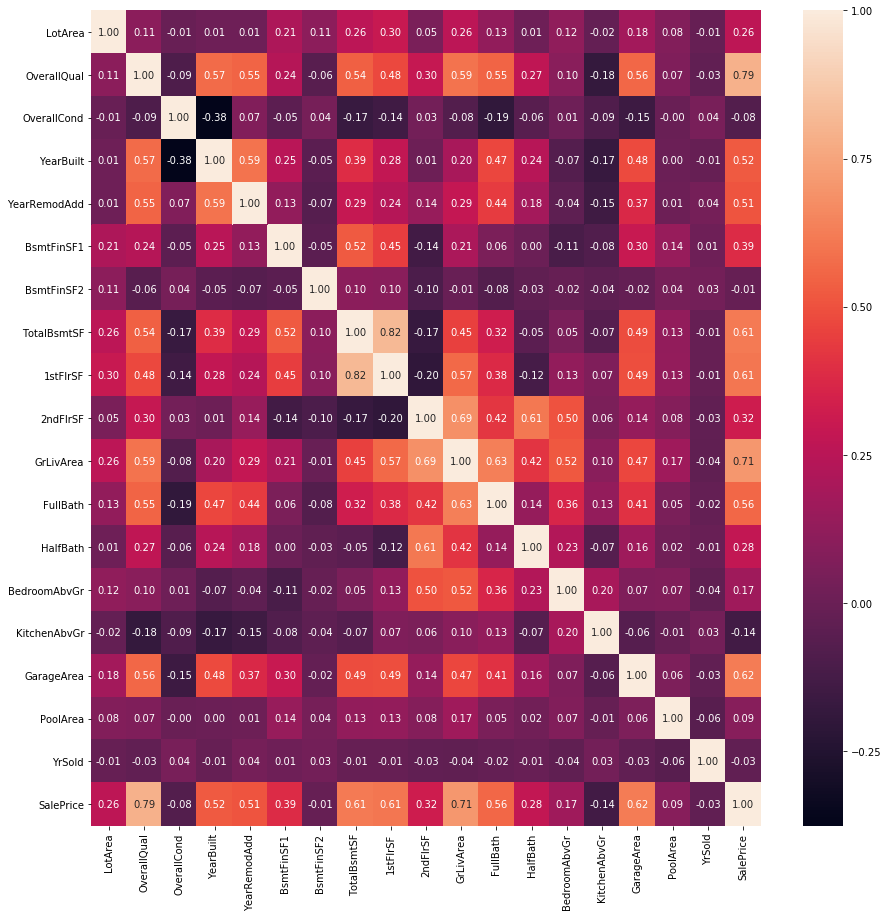

In [0]:
# TODO: show visualization

interesting_corr = train_data_full[interesting_cols].corr()
plt.figure(figsize = (15,15))
sns.heatmap(interesting_corr, annot =True, fmt='.2f')

In [0]:
interesting_corr.unstack().sort_values().drop_duplicates()[:10]

YearBuilt     OverallCond    -0.376
1stFlrSF      2ndFlrSF       -0.203
OverallCond   FullBath       -0.194
KitchenAbvGr  OverallQual    -0.184
YearBuilt     KitchenAbvGr   -0.175
2ndFlrSF      TotalBsmtSF    -0.175
OverallCond   TotalBsmtSF    -0.171
GarageArea    OverallCond    -0.152
YearRemodAdd  KitchenAbvGr   -0.150
OverallCond   1stFlrSF       -0.144
dtype: float64

**top 3 negative correlations!**




```
OverallCond   YearBuilt      -0.376
1stFlrSF      2ndFlrSF       -0.203
OverallCond   FullBath       -0.194
```




In [0]:
interesting_corr.replace(1,0).unstack().sort_values(ascending=False).drop_duplicates()[:10]

TotalBsmtSF  1stFlrSF      0.820
OverallQual  SalePrice     0.791
GrLivArea    SalePrice     0.709
2ndFlrSF     GrLivArea     0.688
FullBath     GrLivArea     0.630
GarageArea   SalePrice     0.623
SalePrice    TotalBsmtSF   0.614
HalfBath     2ndFlrSF      0.610
1stFlrSF     SalePrice     0.606
GrLivArea    OverallQual   0.593
dtype: float64

**top 3 positive correlations!**




```
TotalBsmtSF  1stFlrSF      0.820
OverallQual  SalePrice     0.791
GrLivArea    SalePrice     0.709
```




Discuss most positive and negative correlations.

Most **positive** correlation is between Total basement surface area and 1st floor surface area, which is obvious, as having more basement surface will most probably provide more surface area on first floor. Another interesting fact I got to know is, Overall quality  is having 0.79 correlation with saleprice which is as expected, however, similar looking variable OverallCond is having negative correlation with both, SalePrice and OverllQual. From this information I can assume, condition and quality are being quite different features as eventhough having better quality (more saleprice), condition may not be good(still more saleprice).

Most **negative** correlation is between OverAllCond and YearBuilt which is quite logical, older houses are more likely to have overall low quality. Interesting fact in negative correlations came out to be between 1st and 2nd floor surface areas. One of the possible cases will be eventhough having larger 1st floor, 2nd floor area doesn't increase along with it. From -0.203 correlation, I can assume that, with increase in 1st floor surface area, 2nd floor area slightly decreases in some houses.

For unstacking corr, referred: https://stackoverflow.com/a/51071640

## Part 2 - Informative Plots
Produce five other informative plots revealing aspects of this data. For each plot, write a
paragraph in your notebook describing what interesting properties your visualization
reveals. These must include:
● at least one line chart
● at least one scatter plot or data map
● at least one histogram or bar chart

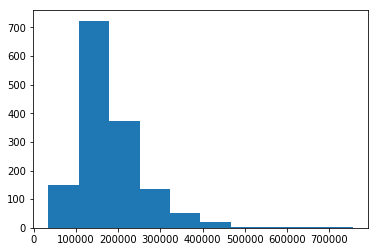

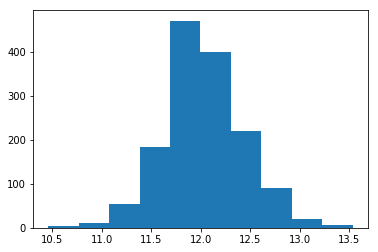

In [0]:
# TODO: code to generate Plot 1


# saleprice distribution


plt.hist(train_data_full['SalePrice'])
plt.show()

plt.hist(np.log(train_data_full['SalePrice']))
plt.show()

What interesting properties does Plot 1 reveal?

This plot reveals saleprice distribution, which is having few outliers after around 4,50,000. Overall the plot is not a normal distribution, but slightly a skewed one. Majority of distribution are around 1,00,000 and 2,00,000 which is logically correct. However, applying log transformation to the data, we are getting almost a normal distribution, which is good and it may help further while data processing.

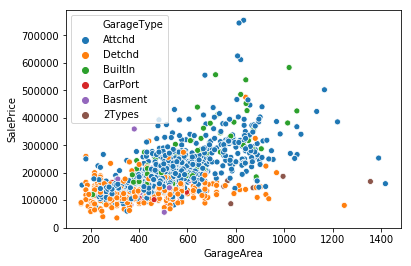

In [0]:
# TODO: code to generate Plot 2


# scatter plot


sns.scatterplot(x="GarageArea", y="SalePrice", data=train_data_full, hue = 'GarageType')

What interesting properties does Plot 2 reveal?

This plot displays combine effect of garage area and type on sale price. Here, garagearea is correlated with saleprice with few outliers. Interesting property is, even when there is a garage having larger area but is detatched, it will not impact much on saleprice in most cases. If it attached or bultin in some cases, then it increases significantly saleprice with larger area.

[]

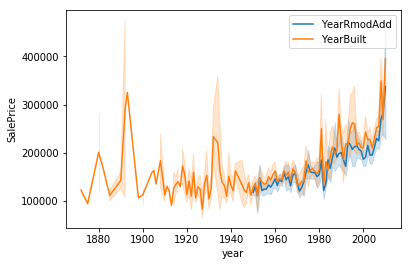

In [0]:
# # TODO: code to generate Plot 3

sns.lineplot(x = 'YearRemodAdd', y='SalePrice', data=train_data_full)
sns.lineplot(x = 'YearBuilt', y='SalePrice', data=train_data_full)
plt.xlabel('year')
plt.legend(labels = ['YearRmodAdd', 'YearBuilt'])
plt.plot()

What interesting properties does Plot 3 reveal?

The line chart shows relation between saleprice and year of built-remodAdd. Interesting fact here is, there is no exact relation between yearbuilt and saleprice. Instead of having somewhat striaght line, it is having many spikes which says houses having built in few specific years before 1950, have higher sale price, not every houses. Main interesting fact is, after 1950 from where YearRmodAdd line starts, line is slightly correlated with saleprice with few spikes (because of inflation or any reasons for specific year duration!). In addition, after ~1950, yearBuilt and yearRmodAdd is having almost similar effect on saleprice.

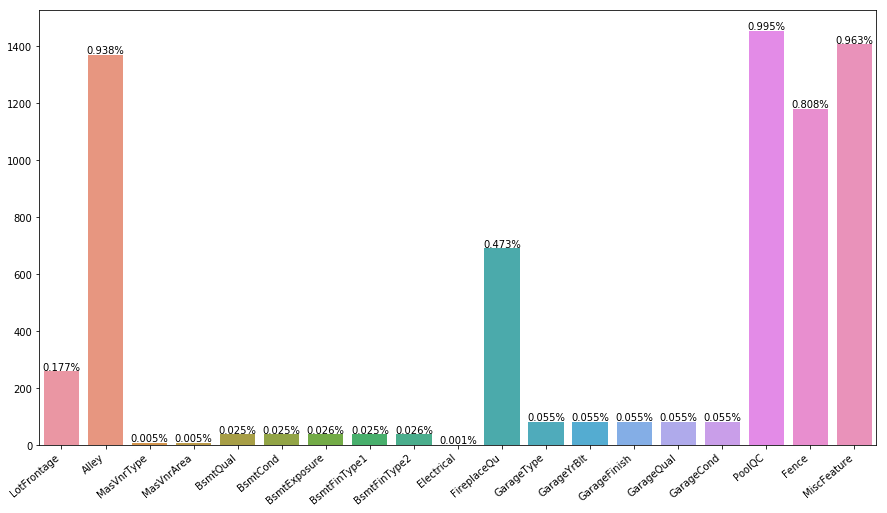

In [0]:
# TODO: code to generate Plot 4

nan_data = train_data_full.loc[:,train_data_full.isna().any()].isna().sum()
plt.figure(figsize=(15,8))
ax = sns.barplot(nan_data.index, nan_data.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# plt.legend()
for patch in ax.patches:
  height = patch.get_height()
  ax.text(patch.get_x()+patch.get_width()/2., height + 4, '{:1.3f}%'.format(height/len(train_data_full)), ha="center")
plt.show()

What interesting properties does Plot 4 reveal?

This bar plot shows nan value ratio in the training data per feature. As it shows, there are 4 features having nan values covering more than 80% data. At first sight, one may think to drop these columns, but for 2 reasons it is not feasible. First, the dataset is not huge and second, these are the features most probably categorical with possible category of None also. Interesting fact also adds information that, eventhough these columns are having nan values, but very relavant features of respective feature are not present in this chart, which means they have some definite values, and by using them, these nan values can be filled.

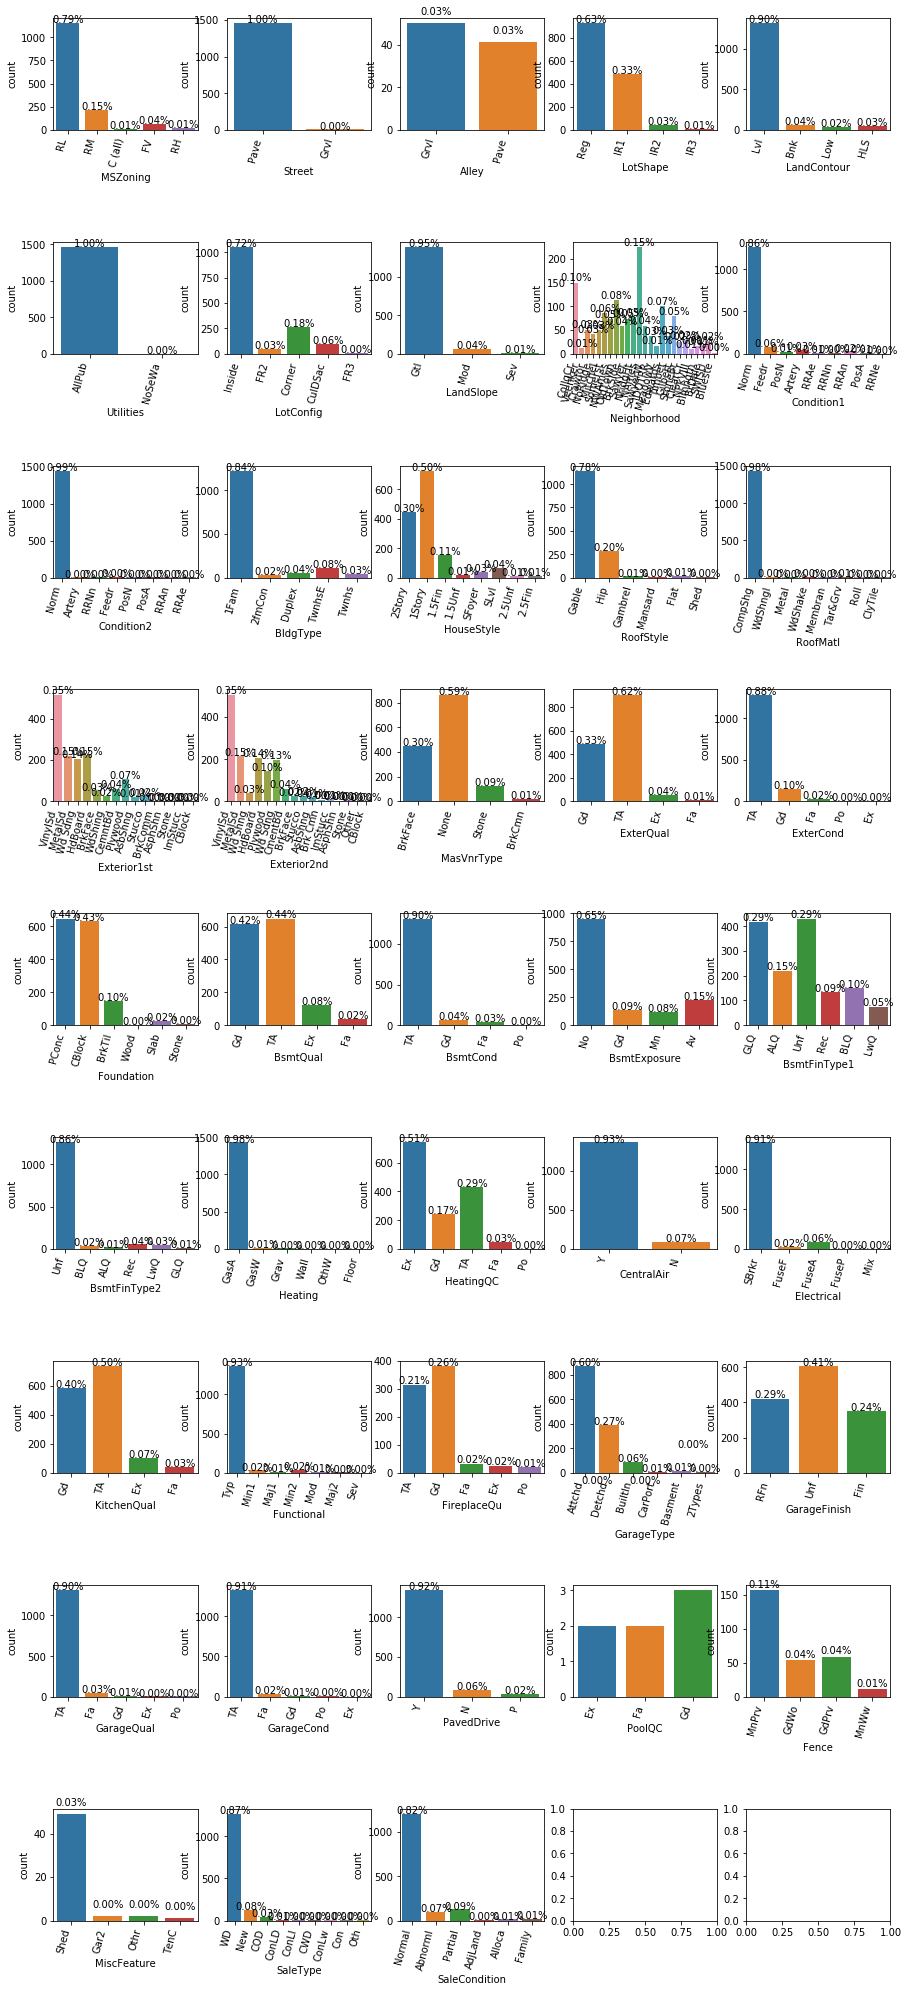

In [0]:
# TODO: code to generate Plot 5

train_data_cat = train_data_full.select_dtypes(include='object')

cols = 5
rows = int(len(train_data_cat.columns)/cols)+1

fig, axes = plt.subplots(rows, cols, figsize=(15,35))
fig.subplots_adjust(hspace=1)
for ax, col in zip(axes.flatten(), train_data_cat.columns):
  ax = sns.countplot(x = col, data = train_data_cat, ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right")
  for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x()+patch.get_width()/2., height + 4, '{:1.2f}%'.format(height/len(train_data_full)), ha="center")
  
plt.show()
  
  

What interesting properties does Plot 5 reveal?

This plot containing many subplots shows distribution of categories per feature. This is required to know about dominant categories or how well balanced given feature is. Interesting properties revealed by this plot is, there are many highly skewed features like more than 90% feature is covered by a single category as well. For an example, heating feature, where GasA is 98% of the feature. There is one feature MiscFeature, whose most dominant category is having only 0.03% which depicts having most of the nan values. Utilities feature has AllPub as 100% (99% I guess). So there will be around only 1 to 5 datapoints of other categories. This plot was very much usefull for the preprocessing approach 2.

## Part 3 - Handcrafted Scoring Function
Build a handcrafted scoring function to rank houses by “desirability”, presumably a notion
related to cost or value. Identify what the ten most desirable and least desirable houses
in the Kaggle data set are, and write a description of which variables your function used
and how well you think it worked.

So, I thought about using **min max normalization** here. By doing this normalization, I can transform each data to **[0,1]** which can be similar having a scoring from 0 to 1 where 1 being best score. Reason behind doing this is, first of all, this normalization transforms the data in [0,1] which can also be considered as similar to probabilities. Secondly, this normalization works on the whole range of data as it gives 0 for minimum data and 1 for maximum data i.e. range is considered from the data itself. If I would have used any other such as Standardization, then it would have treated mean as 0 and standard deviation as 1 which won't be correct for our case as we want comparison here, and in fact I am getting desirable house from the given options, not from possible options.
Then I have added weight factor as well. For me, there are 3 levels of desirabilities: high, medium, low (same like in priorities). So after getting data ranging in [0,1], I am multiplying them with respective weight factors using these levels, boosting scores according to level of desriabilities. 
Finally, I am taking average of them to define a score for a particular house.

For me the variables which decide the desirablity are as followed:

```
'LotArea':'High',
'OverallQual':'High',
'GrLivArea': 'High',
'BedroomAbvGr': 'High',
'FullBath': 'Medium',
'TotalBsmtSF':'Medium',
'2ndFlrSF': 'Medium',
'KitchenAbvGr': 'Low'
```




In [0]:
# TODO: code for scoring function

def norm(x, axis=0):
  return (x - np.min(x, axis=axis))/(np.max(x, axis=axis) - np.min(x, axis=axis))
  
desirable_variables = {
    'LotArea':'High',
    'OverallQual':'High',
    'GrLivArea': 'High',
    'BedroomAbvGr': 'High',
    'FullBath': 'Medium',
    'TotalBsmtSF':'Medium',
    '2ndFlrSF': 'Medium',
    'KitchenAbvGr': 'Low'
}
qualFact = {
    'High':3,
    'Medium':2,
    'Low':1
}
train_data_des = train_data_full[desirable_variables.keys()]

train_data_des = norm(train_data_des, axis=0)

result = np.mean([qualFact[desirable_variables[col]] * train_data_des[col] for col in desirable_variables.keys()], axis=0)
least_desirable_houses = np.argsort(result)[:10]
most_desirable_houses = np.argsort(result)[::-1][:10]

What is the ten most desirable houses?

In [0]:
train_data_full.iloc[most_desirable_houses][desirable_variables.keys()]

,LotArea,OverallQual,GrLivArea,BedroomAbvGr,FullBath,TotalBsmtSF,2ndFlrSF,KitchenAbvGr
1298,63887,10,5642,3,2,6110,950,1
1182,15623,10,4476,4,3,2396,2065,1
691,21535,10,4316,4,3,2444,1872,1
523,40094,10,4676,3,3,3138,1538,1
1169,35760,10,3627,4,3,1930,1796,1
769,53504,8,3279,4,3,1650,1589,1
635,10896,6,3395,8,2,1440,1440,2
185,22950,10,3608,4,2,1107,1518,1
58,13682,10,2945,3,3,1410,1519,1
798,13518,9,3140,4,3,1926,1174,1


What is the ten least desirable houses?

In [0]:
train_data_full.iloc[least_desirable_houses][desirable_variables.keys()]

,LotArea,OverallQual,GrLivArea,BedroomAbvGr,FullBath,TotalBsmtSF,2ndFlrSF,KitchenAbvGr
375,10020,1,904,1,0,683,0,1
916,9000,2,480,1,0,480,0,1
533,5000,1,334,1,1,0,0,1
1100,8400,2,438,1,1,290,0,1
1213,10246,4,960,0,0,648,0,1
636,6120,2,800,1,1,264,0,1
1321,6627,3,720,2,1,0,0,1
29,6324,4,520,1,1,520,0,1
1163,12900,4,1258,0,0,1198,0,2
1039,1477,4,630,1,1,630,0,1


Describe your scoring function and how well you think it worked.

In [0]:
train_data_full['SalePrice'].corr(pd.Series(result))

0.7288289364915396

I think this function works pretty good as we can see in the tables, houses are sorted according to the desirabilities(features from left to right are by high to low priorities). The desirability scores are having high correlation with sale price i.e. 0.75. Though the correlation score depends on the desirable features, 0.75 is considerably good for the function.

*   In **most desirable** houses, 2nd and 3rd houses are having almost similar features, but 3rd one has a lead in lot area (whose priority is higher) so one may say that 3rd house should be at 2nd position, but 2nd house is leading in features of GrLivArea and 2ndFlrSF. Though they have medium and low priorities, their difference contribute enough to keep this house at 2nd position. 
*   Lets take a look at **least desirable** houses.If we compare first two houses, it looks like 1st (least) house is having more lot area, more grLivArea and more totalBsmtSf. Still its score is lesser than 2nd (least). Reason is, though 1st house leads in few columns, that leading difference is not much respective to the feature and so it does not contribute enough to beat the 2nd house, and 2nd house leads in overallQual by 1 point which has higher priority. In real world also, people will consider 1 more point in overllQual than 1000 more lotarea (which is quite less when comparing 9k and 10k).


Hence, I can say that, this scoring function takes consideration of priorities well enough with the features, no matter what feature it is because they are normalised properly.

## Part 4 - Pairwise Distance Function
Define a house “pairwise distance function”, which measures the similarity of two
properties. Like a distance metric, similar pairs of very similar properties should be
distance near zero, with distance increasing as the properties grow more dissimilar.
Experiment with your distance function, and write a discussion evaluating how well you
think it worked. When did it do well and when badly?

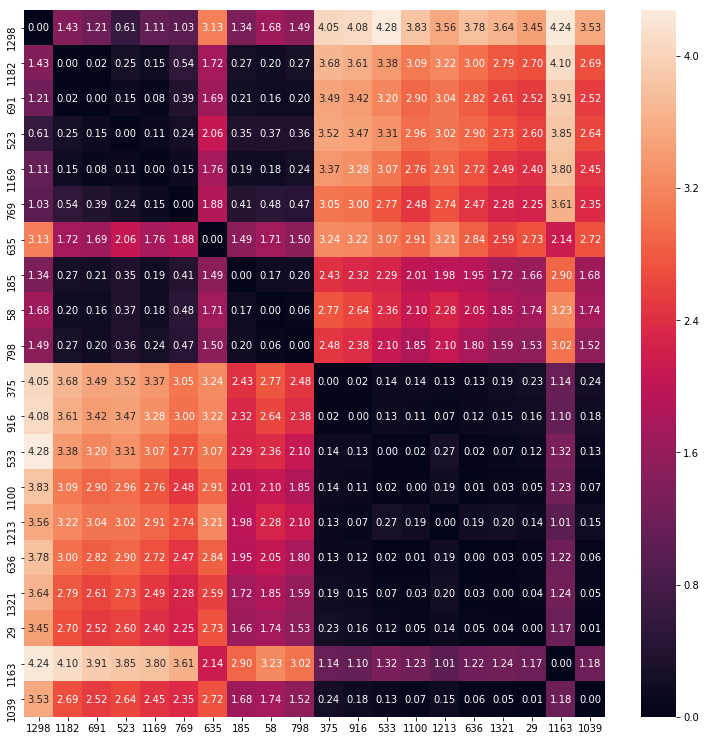

In [0]:
# # # TODO: code for distance function
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def pairwise_distance(x1, x2):
  p1 = abs((x1) - (x2))
  distance = np.sum(np.square(p1))
  return distance

train_data_4_cols = desirable_variables.keys()
train_data_4_df = train_data_full[train_data_4_cols]

indices = list(train_data_full.iloc[most_desirable_houses][desirable_variables.keys()].index)
indices2 = list(train_data_full.iloc[least_desirable_houses][desirable_variables.keys()].index)
indices.extend(indices2)


train_data_4_df = train_data_4_df.loc[indices,]
pairwise_top = pd.DataFrame(
    squareform(pdist(norm(train_data_4_df), metric=pairwise_distance)),
    columns = train_data_4_df.index,
    index = train_data_4_df.index
)

# plot it with seaborn
plt.figure(figsize=(13,13))
sns.heatmap(
    pairwise_top,
    annot =True, fmt='.2f'
)


How well does the distance function work? When does it do well/badly?

Here I have plotted correlation between top most and least desirable houses distances. Function is getting low distance when compared between top most or top least desirable houses, and higher distances when compared 1 house from top desirable and another from least desirable houses. This is what function was expected to do. Therefore, I believe this function is doing a great job. Function calculates euclidian distance after doing min max normalisation. Reason behind using euclidian distance was to show difference higher by squaring. In the heatmap, 2 houses are having higher difference among similar list because the list was built consering desirability that did not select all similar houses together.

## Part 5 - Clustering
Using your distance function and an appropriate clustering algorithm, cluster the houses
using your distance function into 5 to 20 classes, as you see best. Present a
visualization illustrating the clusters your method produced. How well do your clusters
reflect neighborhood boundaries? (do not use neighborhood in your distance function)
Write a discussion/analysis of what your clusters seem to be capturing, and how well
they work.

total datapoints displayed 1460


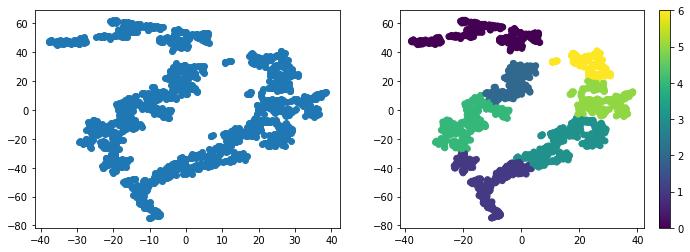

In [0]:
# TODO: code for clustering and visualization

def norm(x, axis=0):
  return (x - np.min(x, axis=axis))/(np.max(x, axis=axis) - np.min(x, axis=axis))

def custom_affinity(X):
    return pairwise_distances(X, metric=pairwise_distance)
  
train_data_full = pd.concat((full_data_num[:train_length],train_sp), axis=1).copy()

train_data_final = train_data_full[desirable_variables.keys()].select_dtypes(include = 'number')

neigh_cols = [c for c in train_data_final.columns if 'neighborhood' in c.lower()]
   
x = train_data_final.copy().drop(neigh_cols, axis=1)  #drop neighborhood column if its there

# x = norm(x)

x = PCA(8).fit_transform(x)
x = TSNE().fit_transform(x)
  
cl = cluster.AgglomerativeClustering(affinity = custom_affinity, linkage = 'average', n_clusters  = 7)
cl.fit(x)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
cmap = plt.cm.get_cmap('jet')
plt.scatter(x[:,0], x[:,1], cmap=plt.cm.coolwarm)


plt.subplot(1,2,2)
plt.scatter(x[:,0], x[:,1], c=cl.labels_)
plt.colorbar()

print("total datapoints displayed", len(x))

How well do the clusters reflect neighborhood boundaries? Write a discussion on what your clusters capture and how well they work.

Clusers are reflecting neighborhood boundaries perfectly. I have used desirable features in this (not 'Neighborhood' feature) and then applied PCA (because t-SNE does not retain distances but probabilities) and then t-SNE, to transform n dimensions to 2 dimensions.The data is clustered in 7 clusters using Agglomerative clustering algorithm and pairwise distances (created in Q.4) is given as metric with linkage as 'average' which uses average of distances of each obeservations! Here the clusters are captured perfectly as similar houses using the Q.4 distance function.

## Part 6 - Linear Regression
Set up a simple linear regression model on one or more variables to predict the pricing
as a function of other variables. How well/badly does it work? Which variable is the most
important one?

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer

reg = LinearRegression()

train_data_final = train_data.copy()

######### simple train and val#########
train_data_final = pd.concat((train_data_final,train_sp), axis=1)

train_data_final = train_data_final.sample(frac = 1, random_state = 2)

split = np.random.RandomState(seed = 3).rand(len(train_data_final)) < 0.8

train_f = train_data_final[split]
val_f = train_data_final[~split]

train_x = train_f.drop(['SalePrice'], axis=1)
train_y = (train_f['SalePrice'])

val_x = val_f.drop(['SalePrice'], axis=1)
val_y = (val_f['SalePrice'])

model = reg.fit(train_x, train_y)
pred_y = model.predict(val_x)
print("validation score", np.abs(rmsle(val_y, pred_y)))

###########cross validation############
x = train_data_final.drop(['SalePrice'], axis=1)
y = (train_data_final['SalePrice'])

score = make_scorer(rmsle, greater_is_better=False)
cv_results = cross_validate(reg, x, y, cv=3, scoring=score)

print("cross validation score", np.abs(np.mean(cv_results['test_score'])))

validation score 0.16608105338150225
cross validation score 0.16722978218049953


How well/badly does it work? Which are the most important variables?

The simple linear regression on the full data is able to gain score 0.16 in validation and cross validation as well after all the preprocessing. Using preprocessing approach 1, I was getting 0.2 score but approach 2 has definitely improved the performance. I think this is a nice score considering linear regression algorithm.

In [0]:
train_x.columns[np.array(reg.coef_).argsort()[-5:][::-1]]

Index(['RoofMatl_WdShngl', 'RoofMatl_Roll', 'RoofMatl_CompShg',
       'RoofMatl_Metal', 'RoofMatl_WdShake'],
      dtype='object')

## Part 7 - External Dataset
Identify at least one external data set which you can integrate into your price prediction
analysis to make it better. Write a discussion/analysis on whether this data helps with the
prediction tasks.

In [0]:
# TODO: code to import external dataset and test

train_data_final = train_data.copy()

In [0]:
years = [0, 1, 2, 3, 4]
months = [i for i in range(0,12)]
# Inflation data
inflation_rate = [0.8,	0.2,	0.6,	0.9,	0.5,	0.2,	0.3,	0.2,	-0.5,	-0.5,	-0.1,	0.1, 
                 0.3,	0.5,	0.9,	0.6,	0.6,	0.2,	0.0,	-0.2,	0.3,	0.2,	0.6,	-0.1,
                 0.5,	0.3,	0.9,	0.6,	0.8,	1.0,	0.5,	-0.4,	-0.1,	-1.0,	-1.9,	-1.0,
                 0.4,	0.5,	0.2,	0.2,	0.3,	0.9,	-0.2,	0.2,	0.1,	0.1,	0.1,	-0.2,
                 0.3,	0.0,	0.4,	0.2,	0.1,	-0.1,	0.0,	0.1,	0.1,	0.1,	0.0,	0.2] # https://www.usinflationcalculator.com/monthly-us-inflation-rates-1913-present/
pci = [
    198.3,	198.7,	199.8,	201.5,	202.5,	202.9,	203.5,	203.9,	202.9,	201.8,	201.5,	201.8,
    202.4,	203.5,	205.4,	206.7,	207.9,	208.4,	208.3,	207.9,	208.5,	208.9,	210.2,	210.0,
    211.1,	211.7,	213.5,	214.8,	216.6,	218.8,	219.964,	219.086,	218.783,	216.573,	212.425,	210.228,
    211.143,	212.193,	212.709,	213.240,	213.856,	215.693,	215.351,	215.834,	215.969,	216.177,	216.330,	215.949,
    216.687,	216.741,	217.631,	218.009,	218.178,	217.965,	218.011,	218.312,	218.439,	218.711,	218.803,	219.179
] # https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/

year_month = [str(i) + str(j) for j in years for i in months]
inflation_data = pd.DataFrame({'year_month':year_month,
                                'inflation_rate':inflation_rate,
                              'pci':pci})


In [0]:
train_data_final['year_month'] = train_data_final['MoSold'].map(str) + train_data_final['YrSold'].map(str)

In [0]:
train_ext = train_data_final.merge(inflation_data, on='year_month', how='left')

In [0]:
interests = pd.read_csv(data_path + 'intRates.csv') # https://fred.stlouisfed.org/series/INTDSRUSM193N

In [0]:
interests['year'] = interests['DATE'].str[-4:].map({
    '2006':0,
    '2007':1,
    '2008':2,
    '2009':3,
    '2010':4
})
interests['month'] = interests['DATE'].str[3:5].map({
    '01':0,
    '02':1,
    '03':2,
    '04':3,
    '05':4,
    '06':5,
    '07':6,
    '08':7,
    '09':8,
    '10':9,
    '11':10,
    '12':11,
})

interests['year_month'] = interests['month'].map(str) + interests['year'].map(str)
interests['interest_rate'] = interests['INTDSRUSM193N']
interests.drop(['DATE', 'INTDSRUSM193N', 'month', 'year'], axis=1, inplace=True)

In [0]:
train_ext2 = train_ext.merge(interests, on='year_month', how='left')

In [0]:
train_ext.drop(['year_month'], axis=1, inplace = True)

In [0]:
train_ext2.drop(['year_month'], axis=1, inplace = True)

In [0]:
# train_data_final = train_data.copy()  # 0.13071439180228125 0.1351469174991443
train_data_final = train_ext.copy()   # 0.13303754581682684  0.1343742262734595
# train_data_final = train_ext2.copy()  # # 0.13392493151891954 0.1350253183018402

######### simple train and val#########
train_data_final = pd.concat((train_data_final,train_sp), axis=1)

train_data_final = train_data_final.sample(frac = 1, random_state = 2)

split = np.random.RandomState(seed = 3).rand(len(train_data_final)) < 0.8

train_f = train_data_final[split]
val_f = train_data_final[~split]

train_x = train_f.drop(['SalePrice'], axis=1)
train_y = (train_f['SalePrice'])

val_x = val_f.drop(['SalePrice'], axis=1)
val_y = (val_f['SalePrice'])

model = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.05, max_depth = 3, loss = 'huber', verbose = 0)
model = model.fit(train_x, train_y)
pred_y = model.predict(val_x)
print("validation score", np.abs(rmsle(val_y, pred_y)))

###########cross validation############
x = train_data_final.drop(['SalePrice'], axis=1)
y = (train_data_final['SalePrice'])

score = make_scorer(rmsle, greater_is_better=False)
cv_results = cross_validate(model, x, y, cv=3, scoring=score)

print("cross validation score", np.abs(np.mean(cv_results['test_score'])))


validation score 0.13296008169151585
cross validation score 0.13340110618573542


Describe the dataset and whether this data helps with prediction.

There are 3 factors I considered which can affect house pricing as per time: inflation, consumer price index, interest rate. So, I looked at the [InflationData](https://www.usinflationcalculator.com/monthly-us-inflation-rates-1913-present/), [ConsumerPriceIndex](https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/) and [InterestRate](https://fred.stlouisfed.org/series/INTDSRUSM193N) data on internet and was able to find it per month and per year data. I thought that I can use such economical factors that will affect house prices such as when inflation is high, prices rise and it is considered as a valuable factor. They have a positive correlation. When Interest rates are low, buying homes can be more affordable. With a constant supply of houses, demand of housing increases and so the house prices. So interest rate can be considered as a useful factor I thought. Another factor is CPI which I have got for the houses itself. Consumer Price Index is a measure of average change of time in prices and somewhat connected to inflation.
I used inflation + CPI as externalData1 and externalData1 + interestRate as externalData2. Because I was spectical about interest rate as it is indirectly affecting the house prices and when we have data of 5 years only(YrSold) so overall interest rate will not be able to contribute much. which came out to be true! So externalData1 could **improve performance by 0.0008** and externalData2 by 0.0001. Experiment could not show significant improvement was known before already but it was a worth try. **Possible reason** according to me is, this new dataset is not having strong features for this particular house dataset. The most important reason behind poor improvement is, the dataset was for whole USA and it was used for Ames in IOWA city. So overall new dataset was not much effective for improvement.

## Part 8 - Permutation Test
For ten different variables (some likely good, some likely meaningless) from the data set,
build single-variable regression models, and for each one do a permutation test to
determine a p -value of how good your predictions of the housing prices are. Use
root-mean-squared error of the log(price) to score your model. In other words, compare
how your model ranks by this metric on the real data compared to 100 (or more) random
permutations of the housing priced assigned to the real data records.

Fireplaces
Score 0.3478232416397868 P Value 0.000999000999000999
**********
3SsnPorch
Score 0.3989864758978304 P Value 0.0969030969030969
**********
ScreenPorch
Score 0.3964506237635726 P Value 0.000999000999000999
**********
BsmtFinSF2
Score 0.39938575858760345 P Value 0.3156843156843157
**********
BsmtHalfBath
Score 0.39925509210321986 P Value 0.1928071928071928
**********
LotArea
Score 0.38570626724351276 P Value 0.000999000999000999
**********
LotFrontage
Score 0.37442421563245926 P Value 0.000999000999000999
**********
ExterQual
Score 0.3245201375180906 P Value 0.000999000999000999
**********
OverallQual
Score 0.3137804470701815 P Value 0.000999000999000999
**********
OverallCond
Score 0.39945244803113883 P Value 0.3546453546453546
**********


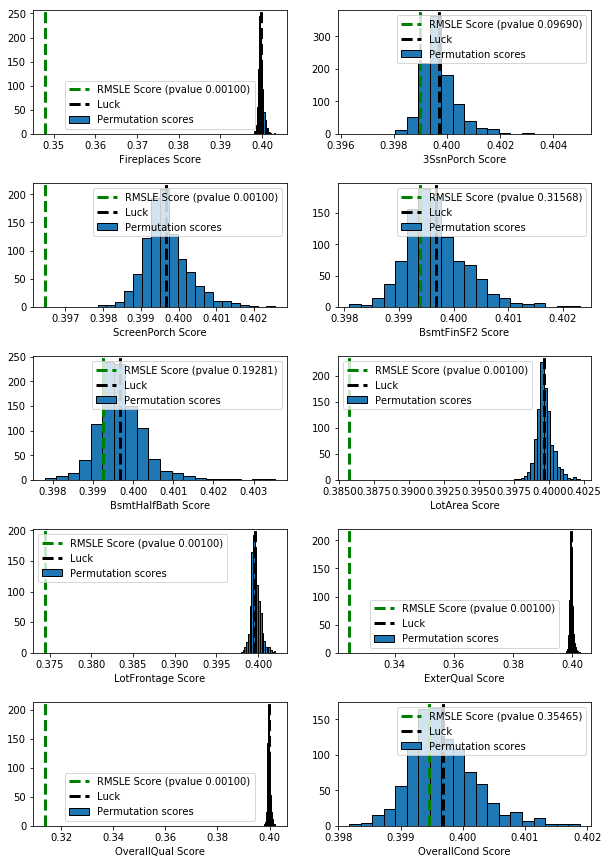

In [0]:
# TODO: code for all permutation tests

variables = ['Fireplaces', '3SsnPorch', 'ScreenPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'LotArea', 'LotFrontage', 'ExterQual', 'OverallQual', 'OverallCond']

train_data_final = train_data.copy()

train_data_final = pd.concat((train_data_final,train_sp), axis=1)

train_data_final = train_data_final.sample(frac = 1)

train_x = train_data_final.drop(['SalePrice'], axis=1)
train_y = (train_data_final['SalePrice'])
  
#### permutation test ####
from sklearn.metrics import make_scorer
rmsle_score = make_scorer(rmsle, greater_is_better=False)
n_permutations = 1000


fig, axes = plt.subplots(5, 2, figsize=(10,15))
fig.subplots_adjust(hspace=0.4)


for ax, var in zip(axes.flatten(), variables):
  if not var == 'SalePrice':
    print(var)
    reg = LinearRegression()

    score, permutation_scores, p_value = permutation_test_score(estimator = reg, X = np.array(norm(train_x[var])).reshape(-1,1), y = train_y, n_permutations = n_permutations, scoring = rmsle_score, cv = 3, n_jobs =-1)
    c = len(permutation_scores[permutation_scores < score])
    p_value = (c + 1) / (n_permutations + 1)
    print("Score", score, "P Value", p_value)
    print('*'*10)
    ax.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
    ylim = ax.get_ylim()

    ax.plot(2 * [score], ylim, '--g', linewidth=3, label='RMSLE Score (pvalue %.5f)' % p_value)
    ax.plot(2 * [np.mean(permutation_scores)], ylim, '--k', linewidth=3, label='Luck')
    ax.set_ylim(ylim)
    ax.legend()
    ax.set_xlabel(var + ' Score')
plt.show()

Describe the results.

Results are as expected. From the columns, few columns are having p values near to 1 which implies performance was more based on luck. These are the columns which are not highly correlated with the target variable SalePrice. The highly correlated features get p value near to 0.009 which implies the model was performing well using those features alone, not based on luck. 

## Part 9 - Final Result
Finally, build the best prediction model you can to solve the task. Use any data, ideas,
and approach that you like. Predict the pricing for instances at file
“sample_submission.csv”. Report the score/rank you get.

In [0]:


# model = KernelRidge(alpha = 0.1, degree = 1) # 0.1748

# model = Lasso(alpha = 0.1, normalize = False, max_iter = 1000, tol = 0.0001, selection = 'random') # 0.1908

# model = lgb.LGBMRegressor(max_depth = 10, learning_rate = 0.05, n_estimators = 1000, objective = 'regression', reg_alpha = 0.01, reg_lambda = 0.5) # 0.1329

# model = xgb.XGBRegressor(learning_rate= 0.05, n_estimators = 1000, reg_alpha = 0.4640, reg_lambda = 0.8571, silent = 1) # 0.1282

model = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.05, max_depth = 3, loss = 'huber', verbose = 0) # 0.1246

#cross validation

train_data_final = train_data.copy()
train_data_final = pd.concat((train_data_final,train_sp), axis=1)
x = train_data_final.drop(['SalePrice'], axis=1)
y = (train_data_final['SalePrice'])

score = make_scorer(rmsle, greater_is_better=False)
cv_results = cross_validate(model, x, y, cv=3, scoring=score)

print("cross validation score", np.mean(cv_results['test_score']))

cross validation score 0.1252751721741692


I started with simple Linear regression which helped me to achieve 0.20 score. After doing required preprocessing, I switched to other regressor where I could tune parameters to improve. I began with KernelRidge which gave me 0.18 the least score for that model after some tuning. This, kernel ridge and lasso are regression models with normalization parameters which can help in avoiding overfitting and along with that gives better performance than simple linear regression. To further improve the performance, I switched to tree algorithms, begining with XGBoost regressor. Some tweaks with parameters improved the score to 0.1363 cross validation score. This improvement motivated me to try few more tree based algorithms: LGBM regressor and Gradient Boosting regressor. The least cross validation score I got was from Grad Boost regression which was 0.1246.

Referred: [Gradient Boosting](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d), [Lightgbm](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc), [XGboost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [0]:
train_x = train_data_final.drop(['SalePrice'], axis=1)
train_y = (train_data_final['SalePrice'])

model = model.fit(train_x, train_y)
pred_y = np.exp(model.predict(test_data))

In [0]:
filename = data_path + 'results/'+ 'pred.csv'

print('output rows', pred_y.shape) # 1459  

pred_data = {'Id': test_ids, 'SalePrice':pred_y}
df = pd.DataFrame(pred_data)
df.to_csv(filename, index = False)

output rows (1459,)


Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: [Profile](https://www.kaggle.com/karanshahstonybrook)

Highest Rank: 1249

Score: 0.12273

Number of entries: 11

INCLUDE IMAGE OF YOUR KAGGLE RANKING
<img src="https://drive.google.com/uc?export=view&id=1qBd0P6YzpUruIow8PmHSAq7I9S4cz5aa">